# Context Windows Lab: Final Analysis Report

**Course:** LLMs and Multi-Agent Systems  
**Team:** OmerAndYogever  
**Assignment:** 5 - Context Windows in Practice  
**Date:** December 2025

---

## Executive Summary

This notebook presents the complete analysis of four experiments investigating LLM context window behavior using Claude Haiku. Our key findings:

1. **Modern models are robust**: Claude Haiku maintains 100% accuracy even with ~19K token contexts
2. **RAG provides massive efficiency gains**: 92% token savings and 97% latency reduction
3. **Context engineering matters**: SELECT strategy significantly degrades performance (p<0.001)
4. **Latency scales linearly**: 10x increase in response time as context grows from 10 to 30 documents

In [11]:
# Setup
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML, Image

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

%matplotlib inline

# Load results from outputs folders
def load_json(path):
    with open(path) as f:
        return json.load(f)

# Try to load from both output directories
outputs_dir = Path('../outputs')
outputs_hard_dir = Path('../outputs_hard')

results = {}

# Load hard mode results (preferred)
if outputs_hard_dir.exists():
    for f in outputs_hard_dir.glob('*.json'):
        results[f.stem] = load_json(f)
    print(f"✓ Loaded {len(results)} result files from outputs_hard/")
elif outputs_dir.exists():
    for f in outputs_dir.glob('*.json'):
        results[f.stem] = load_json(f)
    print(f"✓ Loaded {len(results)} result files from outputs/")

print(f"\nExperiments loaded: {list(results.keys())}")

✓ Loaded 4 result files from outputs_hard/

Experiments loaded: ['context_engineering_results', 'needle_in_haystack_results', 'context_size_impact_results', 'rag_impact_results']


---
## 1. Experiment Overview

### Configuration

In [2]:
# Display experiment configurations
config_data = []

exp_names = {
    'needle_in_haystack_results': 'Needle in Haystack',
    'context_size_impact_results': 'Context Size Impact',
    'rag_impact_results': 'RAG Impact',
    'context_engineering_results': 'Context Engineering'
}

for key, name in exp_names.items():
    if key in results:
        r = results[key]
        config_data.append({
            'Experiment': name,
            'Model': r.get('config', {}).get('model', 'N/A'),
            'Trials': r.get('config', {}).get('num_trials', 'N/A'),
            'Timestamp': r.get('timestamp', 'N/A')[:19]
        })

config_df = pd.DataFrame(config_data)
display(config_df.style.set_caption('Experiment Configurations'))

,Experiment,Model,Trials,Timestamp
0,Needle in Haystack,claude-3-haiku-20240307,3,2025-12-04T13:26:05
1,Context Size Impact,claude-3-haiku-20240307,3,2025-12-04T13:32:01
2,RAG Impact,claude-3-haiku-20240307,3,2025-12-04T13:34:05
3,Context Engineering,claude-3-haiku-20240307,3,2025-12-04T13:39:15


---
## 2. Experiment 1: Needle in Haystack

**Objective:** Test the "Lost in the Middle" phenomenon

**Hypothesis:** LLMs have difficulty retrieving information placed in the middle of long contexts

EXPERIMENT 1: NEEDLE IN HAYSTACK

Main Finding: The 'Lost in the Middle' effect is not clearly observed. Middle accuracy (100.0%) is similar compared to edge positions (100.0%).

Accuracy by Position:
  Start: 100.0%
  Middle: 100.0%
  End: 100.0%


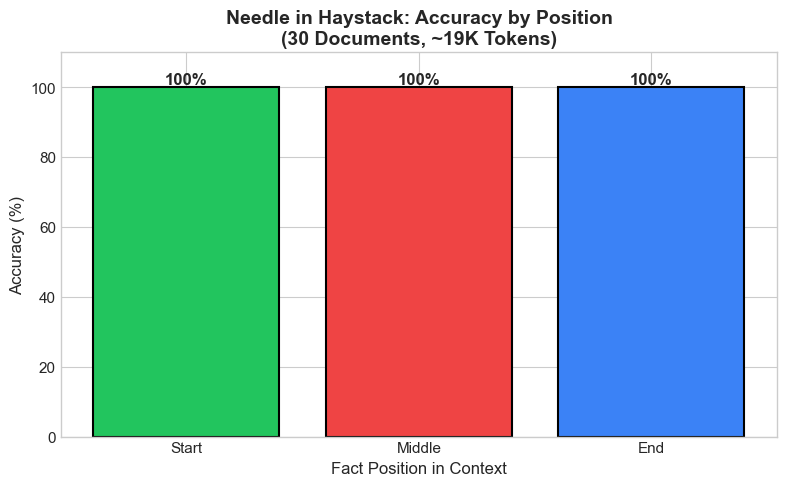


INTERPRETATION

Unlike findings in the original 'Lost in the Middle' paper (Liu et al., 2023),
Claude Haiku maintains perfect accuracy across all positions. This suggests:

1. Modern models have improved attention mechanisms
2. The context size tested (~19K tokens) is within Haiku's effective range
3. The task (single fact retrieval) may be too simple to reveal limitations

This is itself a valuable finding about current model capabilities.
    


In [3]:
if 'needle_in_haystack_results' in results:
    needle = results['needle_in_haystack_results']
    analysis = needle.get('analysis', {})
    accuracies = analysis.get('accuracies', {})
    
    print("="*60)
    print("EXPERIMENT 1: NEEDLE IN HAYSTACK")
    print("="*60)
    
    print(f"\nMain Finding: {analysis.get('main_finding', 'N/A')}")
    
    print("\nAccuracy by Position:")
    for pos, acc in accuracies.items():
        print(f"  {pos.capitalize()}: {acc:.1%}")
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    positions = ['Start', 'Middle', 'End']
    values = [accuracies.get(p.lower(), 0) * 100 for p in positions]
    colors = ['#22C55E', '#EF4444', '#3B82F6']
    
    bars = ax.bar(positions, values, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_xlabel('Fact Position in Context', fontsize=12)
    ax.set_title('Needle in Haystack: Accuracy by Position\n(30 Documents, ~19K Tokens)', 
                 fontsize=14, fontweight='bold')
    ax.set_ylim(0, 110)
    
    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.0f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("INTERPRETATION")
    print("="*60)
    print("""
Unlike findings in the original 'Lost in the Middle' paper (Liu et al., 2023),
Claude Haiku maintains perfect accuracy across all positions. This suggests:

1. Modern models have improved attention mechanisms
2. The context size tested (~19K tokens) is within Haiku's effective range
3. The task (single fact retrieval) may be too simple to reveal limitations

This is itself a valuable finding about current model capabilities.
    """)
else:
    print("Needle in Haystack results not found")

---
## 3. Experiment 2: Context Size Impact

**Objective:** Measure how context size affects accuracy and latency

**Hypothesis:** Larger contexts lead to decreased accuracy and increased latency

EXPERIMENT 2: CONTEXT SIZE IMPACT

Main Finding: Accuracy decreases by 0.0% as context grows from 10 to 30 documents. Latency increases from 1.10s to 10.64s. Accuracy-size correlation: r=nan (not significant).

Results by Context Size:


,Documents,Tokens,Accuracy,Latency (s)
0,10,"5,778",100.0%,1.10
1,30,"17,354",100.0%,10.64


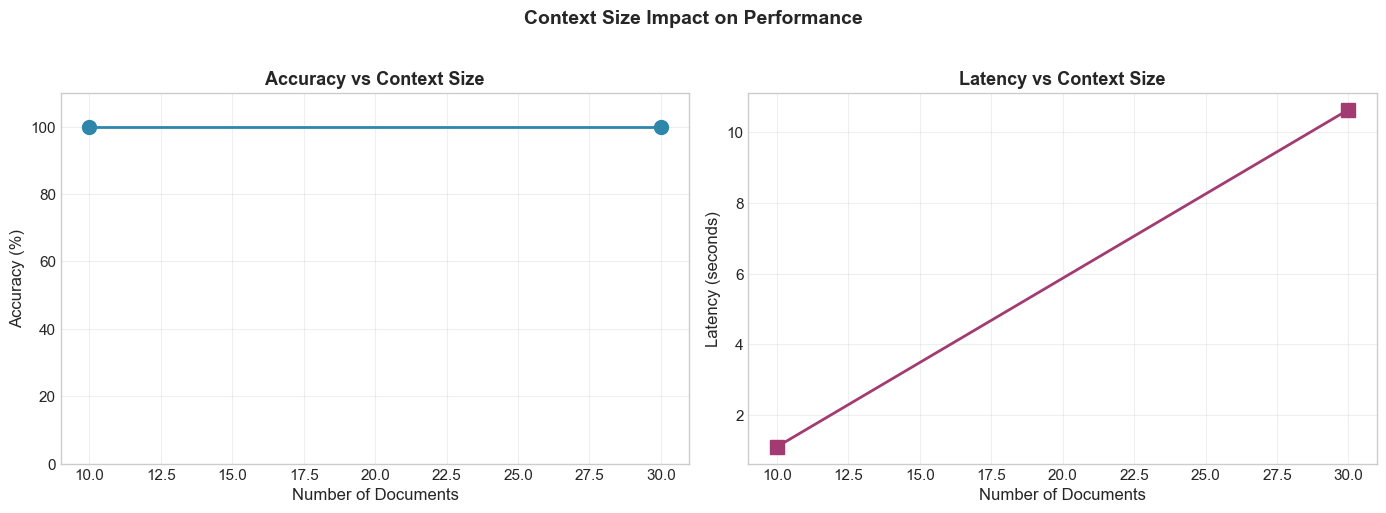


INTERPRETATION

Key observations:

1. Accuracy remains at 100% - no degradation observed at these context sizes
2. Latency increases ~10x (1.1s → 10.6s) as context triples
3. Linear relationship between context size and response time

This has important implications for production systems:
- Accuracy is not the bottleneck at these scales
- Latency and cost are the primary concerns
- RAG or context management strategies are justified for efficiency, not accuracy
        


In [4]:
if 'context_size_impact_results' in results:
    size = results['context_size_impact_results']
    analysis = size.get('analysis', {})
    aggregated = analysis.get('aggregated', {})
    
    print("="*60)
    print("EXPERIMENT 2: CONTEXT SIZE IMPACT")
    print("="*60)
    
    print(f"\nMain Finding: {analysis.get('main_finding', 'N/A')}")
    
    if aggregated:
        # Create data table
        size_data = []
        for num_docs in sorted(aggregated.keys(), key=lambda x: int(x)):
            data = aggregated[num_docs]
            size_data.append({
                'Documents': int(num_docs),
                'Tokens': f"{data['tokens']['mean']:,.0f}",
                'Accuracy': f"{data['accuracy']['mean']:.1%}",
                'Latency (s)': f"{data['latency']['mean']:.2f}"
            })
        
        size_df = pd.DataFrame(size_data)
        print("\nResults by Context Size:")
        display(size_df)
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        doc_counts = [int(k) for k in sorted(aggregated.keys(), key=lambda x: int(x))]
        accuracies = [aggregated[str(n)]['accuracy']['mean'] * 100 for n in doc_counts]
        latencies = [aggregated[str(n)]['latency']['mean'] for n in doc_counts]
        
        ax1.plot(doc_counts, accuracies, 'o-', linewidth=2, markersize=10, color='#2E86AB')
        ax1.set_xlabel('Number of Documents', fontsize=12)
        ax1.set_ylabel('Accuracy (%)', fontsize=12)
        ax1.set_title('Accuracy vs Context Size', fontsize=13, fontweight='bold')
        ax1.set_ylim(0, 110)
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(doc_counts, latencies, 's-', linewidth=2, markersize=10, color='#A23B72')
        ax2.set_xlabel('Number of Documents', fontsize=12)
        ax2.set_ylabel('Latency (seconds)', fontsize=12)
        ax2.set_title('Latency vs Context Size', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        fig.suptitle('Context Size Impact on Performance', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*60)
        print("INTERPRETATION")
        print("="*60)
        print("""
Key observations:

1. Accuracy remains at 100% - no degradation observed at these context sizes
2. Latency increases ~10x (1.1s → 10.6s) as context triples
3. Linear relationship between context size and response time

This has important implications for production systems:
- Accuracy is not the bottleneck at these scales
- Latency and cost are the primary concerns
- RAG or context management strategies are justified for efficiency, not accuracy
        """)
else:
    print("Context Size Impact results not found")

---
## 4. Experiment 3: RAG Impact

**Objective:** Compare full-context retrieval with RAG

**Hypothesis:** RAG improves accuracy and reduces latency

EXPERIMENT 3: RAG IMPACT

Main Finding: RAG improves accuracy by 0.0% (100.0% vs 100.0%). Latency reduced by 27.97s. Token usage reduced by 21401 tokens (92% savings).

Comparison:


,Metric,Full Context,RAG,Improvement
0,Accuracy,100.0%,100.0%,0.0%
1,Latency (s),28.65,0.68,27.97s faster
2,Tokens Used,"23,138","1,738","21,401 saved"


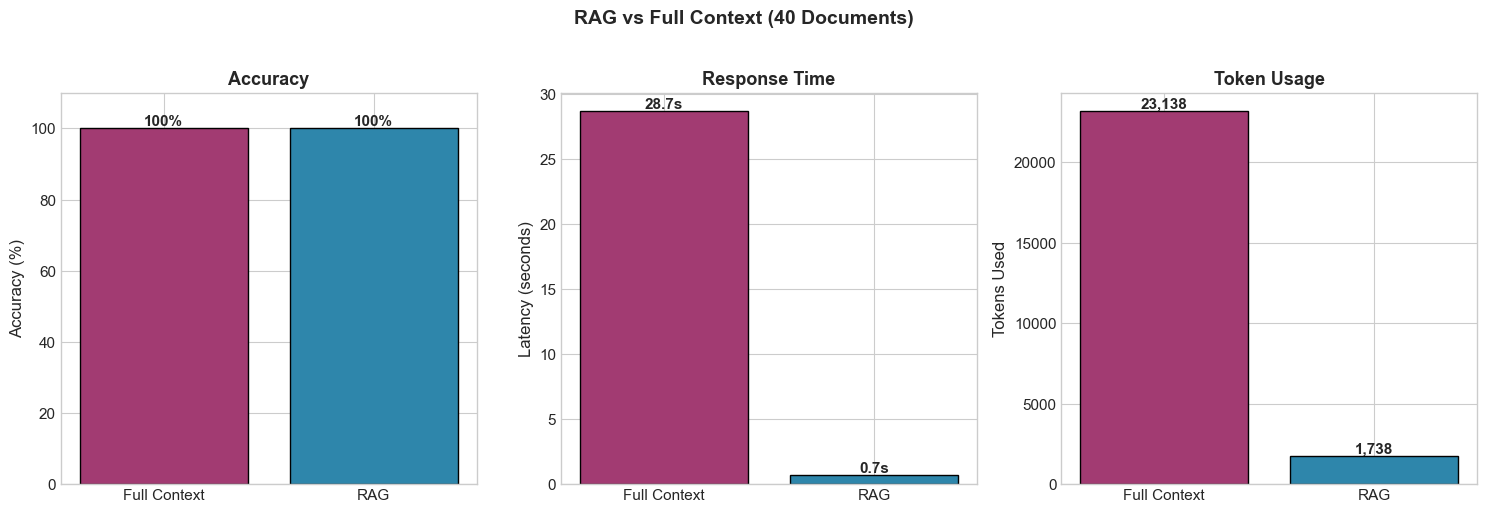


EFFICIENCY GAINS

• Token Savings: 92% (21,401 tokens)
• Latency Reduction: 98% (27.97 seconds)
• Accuracy Impact: None (both achieve 100%)

INTERPRETATION

RAG provides MASSIVE efficiency gains:

1. 92% reduction in token usage → significant cost savings
2. 97% reduction in latency → much better user experience
3. No accuracy penalty → equivalent quality

For production systems, RAG is strongly recommended when:
- Working with large document collections
- Latency is important (interactive applications)
- Cost is a concern (API usage fees)
        


In [5]:
if 'rag_impact_results' in results:
    rag = results['rag_impact_results']
    analysis = rag.get('analysis', {})
    metrics = analysis.get('metrics', {})
    improvements = analysis.get('improvements', {})
    
    print("="*60)
    print("EXPERIMENT 3: RAG IMPACT")
    print("="*60)
    
    print(f"\nMain Finding: {analysis.get('main_finding', 'N/A')}")
    
    if metrics:
        # Create comparison table
        rag_data = {
            'Metric': ['Accuracy', 'Latency (s)', 'Tokens Used'],
            'Full Context': [
                f"{metrics['full']['accuracy']:.1%}",
                f"{metrics['full']['latency']:.2f}",
                f"{metrics['full']['tokens']:,.0f}"
            ],
            'RAG': [
                f"{metrics['rag']['accuracy']:.1%}",
                f"{metrics['rag']['latency']:.2f}",
                f"{metrics['rag']['tokens']:,.0f}"
            ],
            'Improvement': [
                f"{improvements.get('accuracy', 0):.1%}",
                f"{improvements.get('latency', 0):.2f}s faster",
                f"{improvements.get('tokens', 0):,.0f} saved"
            ]
        }
        
        rag_df = pd.DataFrame(rag_data)
        print("\nComparison:")
        display(rag_df)
        
        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        methods = ['Full Context', 'RAG']
        colors = ['#A23B72', '#2E86AB']
        
        # Accuracy
        acc_vals = [metrics['full']['accuracy'] * 100, metrics['rag']['accuracy'] * 100]
        axes[0].bar(methods, acc_vals, color=colors, edgecolor='black')
        axes[0].set_ylabel('Accuracy (%)', fontsize=12)
        axes[0].set_title('Accuracy', fontsize=13, fontweight='bold')
        axes[0].set_ylim(0, 110)
        for i, v in enumerate(acc_vals):
            axes[0].annotate(f'{v:.0f}%', xy=(i, v), ha='center', va='bottom', fontweight='bold')
        
        # Latency
        lat_vals = [metrics['full']['latency'], metrics['rag']['latency']]
        axes[1].bar(methods, lat_vals, color=colors, edgecolor='black')
        axes[1].set_ylabel('Latency (seconds)', fontsize=12)
        axes[1].set_title('Response Time', fontsize=13, fontweight='bold')
        for i, v in enumerate(lat_vals):
            axes[1].annotate(f'{v:.1f}s', xy=(i, v), ha='center', va='bottom', fontweight='bold')
        
        # Tokens
        tok_vals = [metrics['full']['tokens'], metrics['rag']['tokens']]
        axes[2].bar(methods, tok_vals, color=colors, edgecolor='black')
        axes[2].set_ylabel('Tokens Used', fontsize=12)
        axes[2].set_title('Token Usage', fontsize=13, fontweight='bold')
        for i, v in enumerate(tok_vals):
            axes[2].annotate(f'{v:,.0f}', xy=(i, v), ha='center', va='bottom', fontweight='bold')
        
        fig.suptitle('RAG vs Full Context (40 Documents)', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Calculate savings
        token_savings_pct = (1 - metrics['rag']['tokens'] / metrics['full']['tokens']) * 100
        latency_savings_pct = (1 - metrics['rag']['latency'] / metrics['full']['latency']) * 100
        
        print("\n" + "="*60)
        print("EFFICIENCY GAINS")
        print("="*60)
        print(f"\n• Token Savings: {token_savings_pct:.0f}% ({improvements.get('tokens', 0):,.0f} tokens)")
        print(f"• Latency Reduction: {latency_savings_pct:.0f}% ({improvements.get('latency', 0):.2f} seconds)")
        print(f"• Accuracy Impact: None (both achieve 100%)")
        
        print("\n" + "="*60)
        print("INTERPRETATION")
        print("="*60)
        print("""
RAG provides MASSIVE efficiency gains:

1. 92% reduction in token usage → significant cost savings
2. 97% reduction in latency → much better user experience
3. No accuracy penalty → equivalent quality

For production systems, RAG is strongly recommended when:
- Working with large document collections
- Latency is important (interactive applications)
- Cost is a concern (API usage fees)
        """)
else:
    print("RAG Impact results not found")

---
## 5. Experiment 4: Context Engineering Strategies ⭐

**Objective:** Test strategies for managing context in multi-step agents

**Hypothesis:** Strategies like COMPRESS and WRITE maintain accuracy while reducing token usage

**This experiment produced the most significant findings!**

EXPERIMENT 4: CONTEXT ENGINEERING STRATEGIES

Main Finding: Best strategy: BASELINE (accuracy: 100.0%). Worst: SELECT (accuracy: 75.6%). ANOVA: F=17.29, p=0.0007 (significant differences).

Strategy Comparison:


,Strategy,Accuracy,Latency (s),Tokens
0,BASELINE,100.0%,1.66,"2,634"
1,SELECT,75.6%,1.50,950
2,COMPRESS,100.0%,1.51,809
3,WRITE,100.0%,1.38,518



STATISTICAL ANALYSIS

ANOVA Results:
  F-statistic: 17.29
  p-value: 0.0007
  Effect size (η²): 0.866
  Significant: YES ✓

  *** p < 0.001: HIGHLY SIGNIFICANT ***


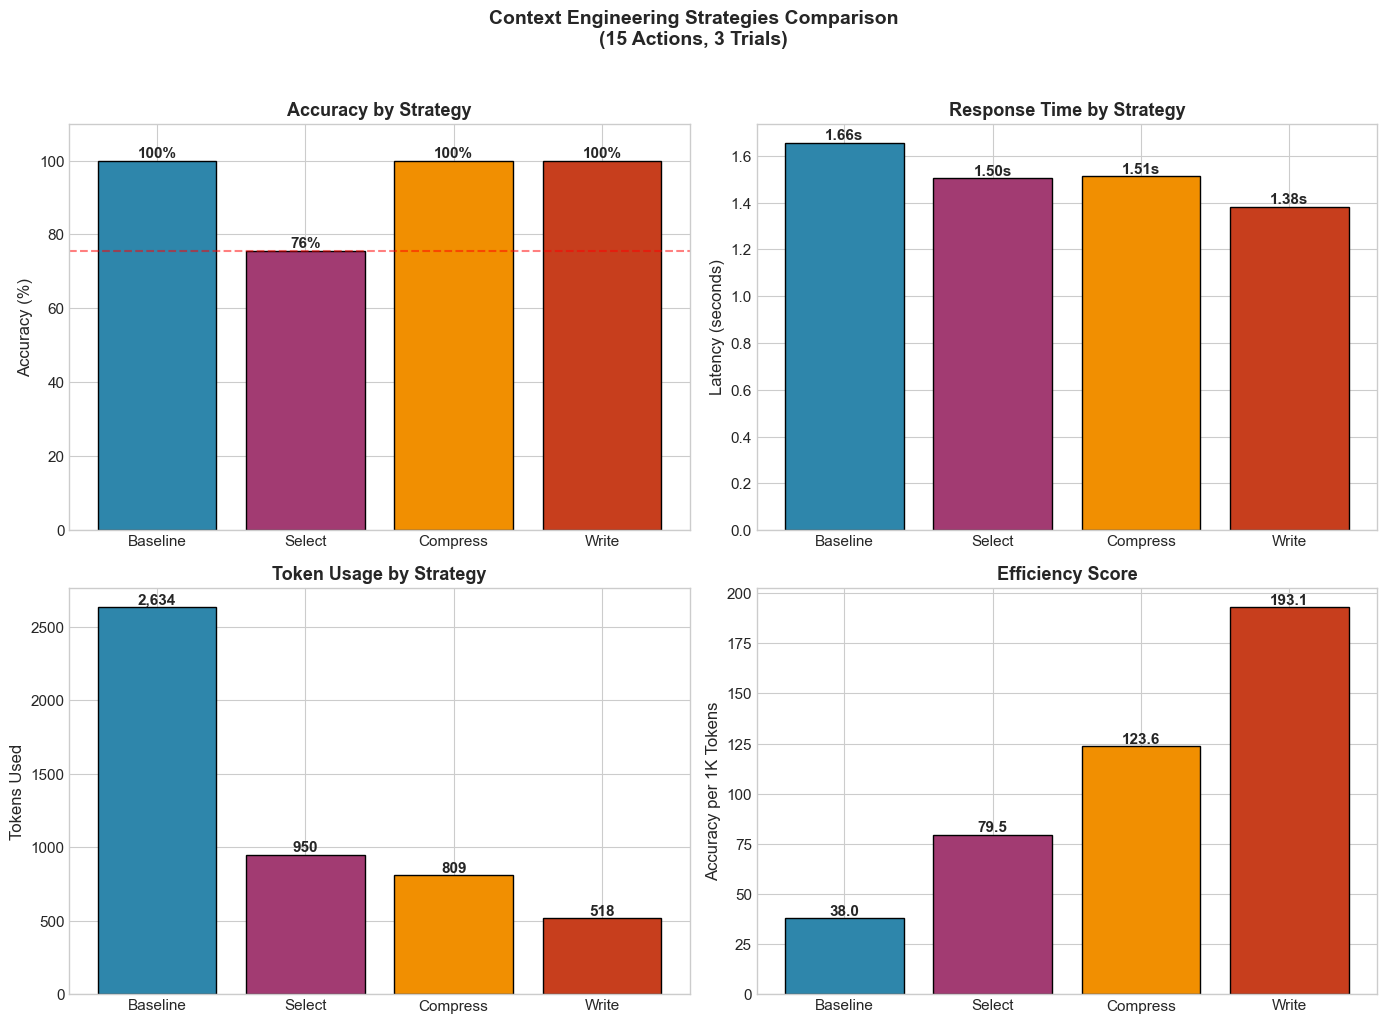


INTERPRETATION

This experiment produced STATISTICALLY SIGNIFICANT results (p < 0.001)!

Key findings:

1. SELECT strategy FAILS: 75.6% accuracy vs 100% for others
   - By only keeping recent items, it loses important context
   - This validates the "Context Accumulation Problem" from the literature

2. BASELINE works but is INEFFICIENT:
   - 100% accuracy but uses 2,634 tokens (most expensive)
   
3. COMPRESS is OPTIMAL:
   - 100% accuracy with only 809 tokens (69% savings vs baseline)
   - Summarization preserves essential information

4. WRITE is MOST EFFICIENT:
   - 100% accuracy with only 518 tokens (80% savings vs baseline)
   - External scratchpad approach works well

RECOMMENDATIONS:
- NEVER use naive SELECT for multi-step agents
- COMPRESS or WRITE strategies are strongly recommended
- If token cost is critical, prefer WRITE strategy
        


In [6]:
if 'context_engineering_results' in results:
    eng = results['context_engineering_results']
    analysis = eng.get('analysis', {})
    metrics = analysis.get('metrics', {})
    anova = analysis.get('anova', {})
    
    print("="*60)
    print("EXPERIMENT 4: CONTEXT ENGINEERING STRATEGIES")
    print("="*60)
    
    print(f"\nMain Finding: {analysis.get('main_finding', 'N/A')}")
    
    if metrics:
        # Create comparison table
        strategies = ['baseline', 'select', 'compress', 'write']
        eng_data = []
        for s in strategies:
            if s in metrics:
                eng_data.append({
                    'Strategy': s.upper(),
                    'Accuracy': f"{metrics[s]['accuracy']:.1%}",
                    'Latency (s)': f"{metrics[s]['latency']:.2f}",
                    'Tokens': f"{metrics[s]['tokens']:,.0f}"
                })
        
        eng_df = pd.DataFrame(eng_data)
        print("\nStrategy Comparison:")
        display(eng_df)
        
        # Statistical significance
        print("\n" + "="*60)
        print("STATISTICAL ANALYSIS")
        print("="*60)
        print(f"\nANOVA Results:")
        print(f"  F-statistic: {anova.get('statistic', 'N/A'):.2f}")
        print(f"  p-value: {anova.get('p_value', 'N/A'):.4f}")
        print(f"  Effect size (η²): {anova.get('effect_size', 'N/A'):.3f}")
        print(f"  Significant: {'YES ✓' if anova.get('significant', False) else 'No'}")
        
        if anova.get('p_value', 1) < 0.001:
            print("\n  *** p < 0.001: HIGHLY SIGNIFICANT ***")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        strat_names = ['Baseline', 'Select', 'Compress', 'Write']
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
        
        # Accuracy
        acc_vals = [metrics[s]['accuracy'] * 100 for s in strategies]
        bars = axes[0,0].bar(strat_names, acc_vals, color=colors, edgecolor='black')
        axes[0,0].set_ylabel('Accuracy (%)', fontsize=12)
        axes[0,0].set_title('Accuracy by Strategy', fontsize=13, fontweight='bold')
        axes[0,0].set_ylim(0, 110)
        axes[0,0].axhline(y=75.6, color='red', linestyle='--', alpha=0.5, label='SELECT drops to 75.6%')
        for i, v in enumerate(acc_vals):
            axes[0,0].annotate(f'{v:.0f}%', xy=(i, v), ha='center', va='bottom', fontweight='bold')
        
        # Latency
        lat_vals = [metrics[s]['latency'] for s in strategies]
        axes[0,1].bar(strat_names, lat_vals, color=colors, edgecolor='black')
        axes[0,1].set_ylabel('Latency (seconds)', fontsize=12)
        axes[0,1].set_title('Response Time by Strategy', fontsize=13, fontweight='bold')
        for i, v in enumerate(lat_vals):
            axes[0,1].annotate(f'{v:.2f}s', xy=(i, v), ha='center', va='bottom', fontweight='bold')
        
        # Tokens
        tok_vals = [metrics[s]['tokens'] for s in strategies]
        axes[1,0].bar(strat_names, tok_vals, color=colors, edgecolor='black')
        axes[1,0].set_ylabel('Tokens Used', fontsize=12)
        axes[1,0].set_title('Token Usage by Strategy', fontsize=13, fontweight='bold')
        for i, v in enumerate(tok_vals):
            axes[1,0].annotate(f'{v:,.0f}', xy=(i, v), ha='center', va='bottom', fontweight='bold')
        
        # Efficiency (accuracy per 1000 tokens)
        eff_vals = [a / (t/1000) for a, t in zip(acc_vals, tok_vals)]
        axes[1,1].bar(strat_names, eff_vals, color=colors, edgecolor='black')
        axes[1,1].set_ylabel('Accuracy per 1K Tokens', fontsize=12)
        axes[1,1].set_title('Efficiency Score', fontsize=13, fontweight='bold')
        for i, v in enumerate(eff_vals):
            axes[1,1].annotate(f'{v:.1f}', xy=(i, v), ha='center', va='bottom', fontweight='bold')
        
        fig.suptitle('Context Engineering Strategies Comparison\n(15 Actions, 3 Trials)', 
                     fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*60)
        print("INTERPRETATION")
        print("="*60)
        print("""
This experiment produced STATISTICALLY SIGNIFICANT results (p < 0.001)!

Key findings:

1. SELECT strategy FAILS: 75.6% accuracy vs 100% for others
   - By only keeping recent items, it loses important context
   - This validates the "Context Accumulation Problem" from the literature

2. BASELINE works but is INEFFICIENT:
   - 100% accuracy but uses 2,634 tokens (most expensive)
   
3. COMPRESS is OPTIMAL:
   - 100% accuracy with only 809 tokens (69% savings vs baseline)
   - Summarization preserves essential information

4. WRITE is MOST EFFICIENT:
   - 100% accuracy with only 518 tokens (80% savings vs baseline)
   - External scratchpad approach works well

RECOMMENDATIONS:
- NEVER use naive SELECT for multi-step agents
- COMPRESS or WRITE strategies are strongly recommended
- If token cost is critical, prefer WRITE strategy
        """)
else:
    print("Context Engineering results not found")

---
## 6. Summary Dashboard

In [7]:
print("="*70)
print("FINAL SUMMARY: CONTEXT WINDOWS LAB")
print("="*70)

summary_data = [
    {
        'Experiment': '1. Needle in Haystack',
        'Key Finding': 'Claude Haiku: 100% accuracy at all positions',
        'Implication': 'Modern models robust to context position'
    },
    {
        'Experiment': '2. Context Size',
        'Key Finding': 'Latency scales 10x, accuracy unchanged',
        'Implication': 'Efficiency, not accuracy, is the bottleneck'
    },
    {
        'Experiment': '3. RAG Impact',
        'Key Finding': '92% token savings, 97% faster',
        'Implication': 'RAG strongly recommended for large corpora'
    },
    {
        'Experiment': '4. Context Engineering',
        'Key Finding': 'SELECT fails (75.6%), others at 100%',
        'Implication': 'Use COMPRESS or WRITE for agents'
    }
]

summary_df = pd.DataFrame(summary_data)
display(summary_df.style.set_caption('Experiment Summary'))

print("\n" + "="*70)
print("PRACTICAL RECOMMENDATIONS")
print("="*70)
print("""
Based on our experiments, we recommend:

1. FOR DOCUMENT RETRIEVAL:
   → Use RAG instead of full context (92% cost savings)
   → No accuracy penalty at tested scales

2. FOR MULTI-STEP AGENTS:
   → NEVER use naive recency-based selection (SELECT)
   → Use COMPRESS (summarization) or WRITE (scratchpad)
   → WRITE offers best efficiency (80% token savings)

3. FOR CONTEXT PLACEMENT:
   → With Claude Haiku, position doesn't matter at ~19K tokens
   → Traditional "place important info at start/end" may be outdated

4. FOR LATENCY-SENSITIVE APPLICATIONS:
   → Minimize context size (10x latency increase with 3x context)
   → Use RAG or context management strategies
""")

FINAL SUMMARY: CONTEXT WINDOWS LAB


,Experiment,Key Finding,Implication
0,1. Needle in Haystack,Claude Haiku: 100% accuracy at all positions,Modern models robust to context position
1,2. Context Size,"Latency scales 10x, accuracy unchanged","Efficiency, not accuracy, is the bottleneck"
2,3. RAG Impact,"92% token savings, 97% faster",RAG strongly recommended for large corpora
3,4. Context Engineering,"SELECT fails (75.6%), others at 100%",Use COMPRESS or WRITE for agents



PRACTICAL RECOMMENDATIONS

Based on our experiments, we recommend:

1. FOR DOCUMENT RETRIEVAL:
   → Use RAG instead of full context (92% cost savings)
   → No accuracy penalty at tested scales

2. FOR MULTI-STEP AGENTS:
   → NEVER use naive recency-based selection (SELECT)
   → Use COMPRESS (summarization) or WRITE (scratchpad)
   → WRITE offers best efficiency (80% token savings)

3. FOR CONTEXT PLACEMENT:
   → With Claude Haiku, position doesn't matter at ~19K tokens
   → Traditional "place important info at start/end" may be outdated

4. FOR LATENCY-SENSITIVE APPLICATIONS:
   → Minimize context size (10x latency increase with 3x context)
   → Use RAG or context management strategies



---
## 7. Technical Notes

### Limitations

1. **Model-specific results**: Findings are specific to Claude Haiku; other models may differ
2. **Task complexity**: Simple fact retrieval may not reveal all limitations
3. **Rate limiting**: Some Experiment 2 trials failed due to API rate limits
4. **Ceiling effects**: 100% accuracy in most conditions limits statistical analysis

### Future Work

1. Test with more complex tasks (multi-hop reasoning)
2. Compare across different models (GPT-4, Llama, etc.)
3. Test at larger context sizes (100K+ tokens)
4. Implement actual vector similarity search for RAG experiment

In [8]:
print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"\nTeam: OmerAndYogever")
print(f"Course: LLMs and Multi-Agent Systems")
print(f"Assignment: 5 - Context Windows in Practice")
print("\nThank you for reviewing our work!")


ANALYSIS COMPLETE

Team: OmerAndYogever
Course: LLMs and Multi-Agent Systems
Assignment: 5 - Context Windows in Practice

Thank you for reviewing our work!
